In [2]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set up path to data
DATA_PATH = Path("../data/dapo-kemdikdasmen/Jawa-Timur")
print(f"Data path: {DATA_PATH}")
print(f"Data path exists: {DATA_PATH.exists()}")

Data path: ..\data\dapo-kemdikdasmen\Jawa-Timur
Data path exists: True


In [3]:
def load_all_facility_data(data_path):
    """
    Load all facility data from JSON files in the directory structure
    """
    all_data = []
    
    # Walk through all kabupaten/kota folders
    for kabupaten_folder in data_path.iterdir():
        if kabupaten_folder.is_dir():
            print(f"Processing: {kabupaten_folder.name}")
            
            # Walk through all kecamatan folders
            for kecamatan_folder in kabupaten_folder.iterdir():
                if kecamatan_folder.is_dir():
                    
                    # Walk through all JSON files (schools)
                    for json_file in kecamatan_folder.glob("*.json"):
                        try:
                            with open(json_file, 'r', encoding='utf-8') as f:
                                school_data = json.load(f)
                                
                            # Add metadata
                            for record in school_data:
                                record['kabupaten'] = kabupaten_folder.name
                                record['kecamatan'] = kecamatan_folder.name
                                record['sekolah'] = json_file.stem
                                all_data.append(record)
                                
                        except Exception as e:
                            print(f"Error reading {json_file}: {e}")
    
    return all_data

# Load all data
print("Loading facility data...")
facility_data = load_all_facility_data(DATA_PATH)
print(f"Total records loaded: {len(facility_data)}")

# Convert to DataFrame
df = pd.DataFrame(facility_data)
print(f"DataFrame shape: {df.shape}")
print("\nFirst few columns:")
print(df.columns.tolist()[:10])

Loading facility data...
Processing: Kab. Bangkalan
Processing: Kab. Banyuwangi
Processing: Kab. Blitar
Processing: Kab. Bojonegoro
Processing: Kab. Bondowoso
Processing: Kab. Gresik
Processing: Kab. Jember
Processing: Kab. Jombang
Processing: Kab. Kediri
Processing: Kab. Lamongan
Processing: Kab. Lumajang
Processing: Kab. Madiun
Processing: Kab. Magetan
Processing: Kab. Malang
Processing: Kab. Mojokerto
Processing: Kab. Nganjuk
Processing: Kab. Ngawi
Processing: Kab. Pacitan
Processing: Kab. Pamekasan
Processing: Kab. Pasuruan
Processing: Kab. Ponorogo
Processing: Kab. Probolinggo
Processing: Kab. Sampang
Processing: Kab. Sidoarjo
Processing: Kab. Situbondo
Processing: Kab. Sumenep
Processing: Kab. Trenggalek
Processing: Kab. Tuban
Processing: Kab. Tulungagung
Processing: Kota Batu
Processing: Kota Blitar
Processing: Kota Kediri
Processing: Kota Madiun
Processing: Kota Malang
Processing: Kota Mojokerto
Processing: Kota Pasuruan
Processing: Kota Probolinggo
Processing: Kota Surabaya
To

In [4]:
def calculate_facility_percentages(df):
    """
    Calculate facility percentages based on 'after' values
    Logic: (current_count / max_count) * 100% per criteria
    """
    
    # Define facility columns (only 'after' columns)
    facility_columns = [
        'after_ruang_kelas',
        'after_ruang_perpus', 
        'after_ruang_lab',
        'after_ruang_praktik',
        'after_ruang_pimpinan',
        'after_ruang_guru',
        'after_ruang_ibadah',
        'after_ruang_uks',
        'after_toilet',
        'after_gudang',
        'after_ruang_sirkulasi',
        'after_tempat_bermain_olahraga',
        'after_ruang_tu',
        'after_ruang_konseling',
        'after_ruang_osis',
        'after_bangunan'
    ]
    
    # Calculate statistics for each facility
    facility_stats = {}
    
    for facility in facility_columns:
        if facility in df.columns:
            # Get current counts (filter out null values)
            current_counts = df[facility].dropna()
            
            # Calculate statistics
            max_count = current_counts.max() if len(current_counts) > 0 else 0
            min_count = current_counts.min() if len(current_counts) > 0 else 0
            mean_count = current_counts.mean() if len(current_counts) > 0 else 0
            total_facilities = current_counts.sum() if len(current_counts) > 0 else 0
            total_schools = len(current_counts)
            
            # Calculate percentage based on max value
            if max_count > 0:
                percentages = (current_counts / max_count) * 100
                avg_percentage = percentages.mean()
            else:
                avg_percentage = 0
            
            facility_stats[facility] = {
                'facility_name': facility.replace('after_', '').replace('_', ' ').title(),
                'total_facilities': total_facilities,
                'total_schools': total_schools,
                'max_count': max_count,
                'min_count': min_count,
                'mean_count': mean_count,
                'avg_percentage_vs_max': avg_percentage,
                'schools_with_facility': len(current_counts[current_counts > 0]),
                'schools_without_facility': len(current_counts[current_counts == 0])
            }
    
    return facility_stats

# Calculate facility percentages
print("Calculating facility percentages...")
facility_percentages = calculate_facility_percentages(df)

# Display results
print("\n" + "="*80)
print("FACILITY PERCENTAGE ANALYSIS (AFTER VALUES)")
print("="*80)

for facility, stats in facility_percentages.items():
    print(f"\n{stats['facility_name']}:")
    print(f"  Total facilities across all schools: {stats['total_facilities']}")
    print(f"  Total schools analyzed: {stats['total_schools']}")
    print(f"  Maximum facilities in a single school: {stats['max_count']}")
    print(f"  Average facilities per school: {stats['mean_count']:.2f}")
    print(f"  Average percentage vs maximum: {stats['avg_percentage_vs_max']:.2f}%")
    print(f"  Schools with this facility: {stats['schools_with_facility']}")
    print(f"  Schools without this facility: {stats['schools_without_facility']}")
    print(f"  Facility availability rate: {(stats['schools_with_facility']/stats['total_schools']*100):.2f}%")

Calculating facility percentages...

FACILITY PERCENTAGE ANALYSIS (AFTER VALUES)

Ruang Kelas:
  Total facilities across all schools: 3374
  Total schools analyzed: 392
  Maximum facilities in a single school: 60
  Average facilities per school: 8.61
  Average percentage vs maximum: 14.35%
  Schools with this facility: 359
  Schools without this facility: 33
  Facility availability rate: 91.58%

Ruang Perpus:
  Total facilities across all schools: 256
  Total schools analyzed: 392
  Maximum facilities in a single school: 3
  Average facilities per school: 0.65
  Average percentage vs maximum: 21.77%
  Schools with this facility: 248
  Schools without this facility: 144
  Facility availability rate: 63.27%

Ruang Lab:
  Total facilities across all schools: 100
  Total schools analyzed: 392
  Maximum facilities in a single school: 3
  Average facilities per school: 0.26
  Average percentage vs maximum: 8.50%
  Schools with this facility: 92
  Schools without this facility: 300
  Facility


FACILITY SUMMARY TABLE:
                                         facility_name  total_facilities  max_count  mean_count  avg_percentage_vs_max  schools_with_facility  schools_without_facility
after_ruang_kelas                          Ruang Kelas              3374         60        8.61                  14.35                    359                        33
after_ruang_perpus                        Ruang Perpus               256          3        0.65                  21.77                    248                       144
after_ruang_lab                              Ruang Lab               100          3        0.26                   8.50                     92                       300
after_ruang_praktik                      Ruang Praktik                50          9        0.13                   1.42                     32                       360
after_ruang_pimpinan                    Ruang Pimpinan               307          3        0.78                  26.11                 

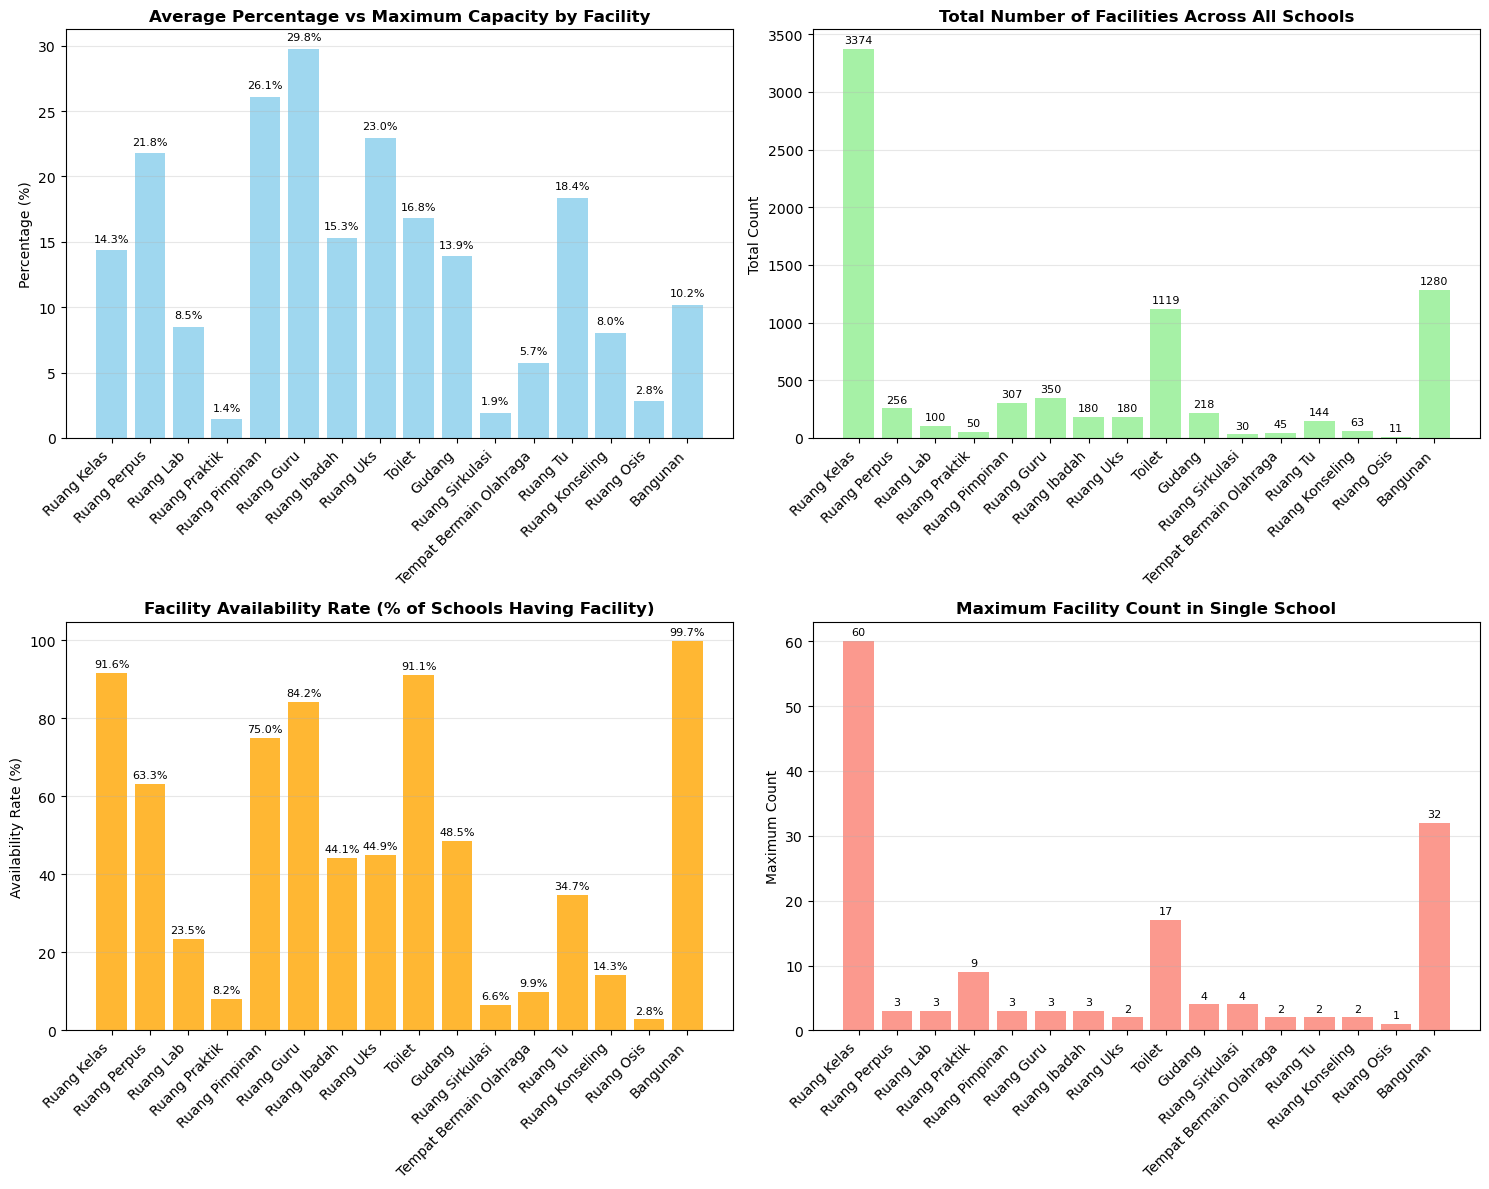

In [5]:
# Create DataFrame for easier visualization
facility_summary_df = pd.DataFrame.from_dict(facility_percentages, orient='index')

print("\nFACILITY SUMMARY TABLE:")
print("="*100)
display_df = facility_summary_df[['facility_name', 'total_facilities', 'max_count', 
                                  'mean_count', 'avg_percentage_vs_max', 
                                  'schools_with_facility', 'schools_without_facility']].round(2)
print(display_df.to_string())

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Average Percentage vs Maximum
ax1 = axes[0, 0]
facility_names = [stats['facility_name'] for stats in facility_percentages.values()]
avg_percentages = [stats['avg_percentage_vs_max'] for stats in facility_percentages.values()]

bars1 = ax1.bar(range(len(facility_names)), avg_percentages, color='skyblue', alpha=0.8)
ax1.set_title('Average Percentage vs Maximum Capacity by Facility', fontsize=12, fontweight='bold')
ax1.set_ylabel('Percentage (%)')
ax1.set_xticks(range(len(facility_names)))
ax1.set_xticklabels(facility_names, rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

# 2. Total Facilities Count
ax2 = axes[0, 1]
total_facilities = [stats['total_facilities'] for stats in facility_percentages.values()]

bars2 = ax2.bar(range(len(facility_names)), total_facilities, color='lightgreen', alpha=0.8)
ax2.set_title('Total Number of Facilities Across All Schools', fontsize=12, fontweight='bold')
ax2.set_ylabel('Total Count')
ax2.set_xticks(range(len(facility_names)))
ax2.set_xticklabels(facility_names, rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + max(total_facilities)*0.01,
             f'{int(height)}', ha='center', va='bottom', fontsize=8)

# 3. Facility Availability Rate
ax3 = axes[1, 0]
availability_rates = [(stats['schools_with_facility']/stats['total_schools']*100) 
                     for stats in facility_percentages.values()]

bars3 = ax3.bar(range(len(facility_names)), availability_rates, color='orange', alpha=0.8)
ax3.set_title('Facility Availability Rate (% of Schools Having Facility)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Availability Rate (%)')
ax3.set_xticks(range(len(facility_names)))
ax3.set_xticklabels(facility_names, rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

# 4. Maximum Capacity by Facility
ax4 = axes[1, 1]
max_counts = [stats['max_count'] for stats in facility_percentages.values()]

bars4 = ax4.bar(range(len(facility_names)), max_counts, color='salmon', alpha=0.8)
ax4.set_title('Maximum Facility Count in Single School', fontsize=12, fontweight='bold')
ax4.set_ylabel('Maximum Count')
ax4.set_xticks(range(len(facility_names)))
ax4.set_xticklabels(facility_names, rotation=45, ha='right')
ax4.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars4):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + max(max_counts)*0.01,
             f'{int(height)}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [6]:
def calculate_detailed_percentages(df):
    """
    Calculate detailed percentages for each school and facility
    Logic: (current_facility_count / max_facility_count_across_all_schools) * 100%
    """
    
    facility_columns = [
        'after_ruang_kelas', 'after_ruang_perpus', 'after_ruang_lab',
        'after_ruang_praktik', 'after_ruang_pimpinan', 'after_ruang_guru',
        'after_ruang_ibadah', 'after_ruang_uks', 'after_toilet',
        'after_gudang', 'after_ruang_sirkulasi', 'after_tempat_bermain_olahraga',
        'after_ruang_tu', 'after_ruang_konseling', 'after_ruang_osis', 'after_bangunan'
    ]
    
    # Create a copy of the dataframe for calculations
    df_calc = df.copy()
    
    # Calculate percentage for each facility
    for facility in facility_columns:
        if facility in df_calc.columns:
            # Get max value across all schools (excluding null values)
            max_value = df_calc[facility].max()
            
            if max_value > 0:
                # Calculate percentage: (current_count / max_count) * 100
                df_calc[f'{facility}_percentage'] = (df_calc[facility] / max_value) * 100
            else:
                df_calc[f'{facility}_percentage'] = 0
            
            # Fill null values with 0
            df_calc[f'{facility}_percentage'] = df_calc[f'{facility}_percentage'].fillna(0)
    
    return df_calc

# Calculate detailed percentages
df_with_percentages = calculate_detailed_percentages(df)

# Show sample calculations for verification
print("SAMPLE PERCENTAGE CALCULATIONS")
print("="*80)
print("Showing first 5 schools with their facility counts and percentages:")
print()

sample_schools = df_with_percentages[['sekolah', 'kabupaten', 'kecamatan']].head()

for idx in sample_schools.index[:5]:
    school_name = df_with_percentages.loc[idx, 'sekolah']
    kabupaten = df_with_percentages.loc[idx, 'kabupaten']
    kecamatan = df_with_percentages.loc[idx, 'kecamatan']
    
    print(f"\nSekolah: {school_name}")
    print(f"Lokasi: {kecamatan}, {kabupaten}")
    print("-" * 60)
    
    # Show facility counts and percentages
    facility_columns = [
        'after_ruang_kelas', 'after_ruang_perpus', 'after_ruang_lab',
        'after_ruang_praktik', 'after_ruang_pimpinan', 'after_ruang_guru'
    ]
    
    for facility in facility_columns:
        if facility in df_with_percentages.columns:
            count = df_with_percentages.loc[idx, facility]
            percentage = df_with_percentages.loc[idx, f'{facility}_percentage']
            max_val = df_with_percentages[facility].max()
            
            facility_name = facility.replace('after_', '').replace('_', ' ').title()
            print(f"{facility_name:20}: {count:3.0f} / {max_val:3.0f} = {percentage:6.2f}%")

print(f"\n\nTotal schools analyzed: {len(df_with_percentages)}")
print(f"Facilities calculated: {len([col for col in df_with_percentages.columns if col.endswith('_percentage')])}")

SAMPLE PERCENTAGE CALCULATIONS
Showing first 5 schools with their facility counts and percentages:


Sekolah: SLB SAMUDRA LAVENDER
Lokasi: Kec. Bangkalan, Kab. Bangkalan
------------------------------------------------------------
Ruang Kelas         :   0 /  60 =   0.00%
Ruang Perpus        :   0 /   3 =   0.00%
Ruang Lab           :   0 /   3 =   0.00%
Ruang Praktik       :   0 /   9 =   0.00%
Ruang Pimpinan      :   0 /   3 =   0.00%
Ruang Guru          :   0 /   3 =   0.00%

Sekolah: SLB PGRI
Lokasi: Kec. Kamal, Kab. Bangkalan
------------------------------------------------------------
Ruang Kelas         :   7 /  60 =  11.67%
Ruang Perpus        :   1 /   3 =  33.33%
Ruang Lab           :   0 /   3 =   0.00%
Ruang Praktik       :   0 /   9 =   0.00%
Ruang Pimpinan      :   1 /   3 =  33.33%
Ruang Guru          :   1 /   3 =  33.33%

Sekolah: SLB NEGERI KELEYAN BANGKALAN
Lokasi: Kec. Socah, Kab. Bangkalan
------------------------------------------------------------
Ruang Kelas    

In [7]:
# Create summary statistics by region
print("\nSUMMARY BY KABUPATEN/KOTA")
print("="*100)

# Group by kabupaten and calculate average percentages
percentage_columns = [col for col in df_with_percentages.columns if col.endswith('_percentage')]

regional_summary = df_with_percentages.groupby('kabupaten')[percentage_columns].agg({
    col: ['mean', 'std', 'min', 'max'] for col in percentage_columns
}).round(2)

# Flatten column names
regional_summary.columns = ['_'.join(col).strip() for col in regional_summary.columns.values]

# Show top 5 kabupaten by average facility percentage
facility_avg_cols = [col for col in regional_summary.columns if col.endswith('_mean')]
regional_summary['overall_avg'] = regional_summary[facility_avg_cols].mean(axis=1)

top_regions = regional_summary.nlargest(5, 'overall_avg')
print("Top 5 Kabupaten/Kota by Average Facility Percentage:")
print(top_regions[['overall_avg']].to_string())

print("\n" + "="*100)
print("FACILITY PERCENTAGE DISTRIBUTION SUMMARY")
print("="*100)

# Calculate overall statistics for each facility type
for facility in ['after_ruang_kelas', 'after_ruang_perpus', 'after_ruang_lab', 'after_ruang_pimpinan']:
    if f'{facility}_percentage' in df_with_percentages.columns:
        facility_name = facility.replace('after_', '').replace('_', ' ').title()
        percentages = df_with_percentages[f'{facility}_percentage']
        
        print(f"\n{facility_name}:")
        print(f"  Average: {percentages.mean():.2f}%")
        print(f"  Median: {percentages.median():.2f}%")
        print(f"  Std Dev: {percentages.std():.2f}%")
        print(f"  Min: {percentages.min():.2f}%")
        print(f"  Max: {percentages.max():.2f}%")
        print(f"  Schools at 100%: {len(percentages[percentages == 100])}")
        print(f"  Schools at 0%: {len(percentages[percentages == 0])}")

# Option to save results to CSV
save_option = input("\nDo you want to save the results to CSV? (y/n): ")
if save_option.lower() == 'y':
    # Save detailed results
    output_file = '../output/facility_percentages_detailed.csv'
    df_with_percentages.to_csv(output_file, index=False)
    print(f"Detailed results saved to: {output_file}")
    
    # Save summary results
    summary_file = '../output/facility_percentages_summary.csv'
    facility_summary_df.to_csv(summary_file)
    print(f"Summary results saved to: {summary_file}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)


SUMMARY BY KABUPATEN/KOTA
Top 5 Kabupaten/Kota by Average Facility Percentage:
                 overall_avg
kabupaten                   
Kota Pasuruan      31.623750
Kab. Trenggalek    22.480000
Kota Kediri        21.537500
Kab. Ponorogo      19.036250
Kab. Jombang       18.711875

FACILITY PERCENTAGE DISTRIBUTION SUMMARY

Ruang Kelas:
  Average: 14.35%
  Median: 11.67%
  Std Dev: 12.63%
  Min: 0.00%
  Max: 100.00%
  Schools at 100%: 1
  Schools at 0%: 33

Ruang Perpus:
  Average: 21.77%
  Median: 33.33%
  Std Dev: 17.58%
  Min: 0.00%
  Max: 100.00%
  Schools at 100%: 2
  Schools at 0%: 144

Ruang Lab:
  Average: 8.50%
  Median: 0.00%
  Std Dev: 16.21%
  Min: 0.00%
  Max: 100.00%
  Schools at 100%: 1
  Schools at 0%: 300

Ruang Pimpinan:
  Average: 26.11%
  Median: 33.33%
  Std Dev: 16.39%
  Min: 0.00%
  Max: 100.00%
  Schools at 100%: 1
  Schools at 0%: 98

ANALYSIS COMPLETE!
